In [1]:
#%run ../Getting_data/Getting_Data.ipynb

In [2]:
import datetime as dt
from datetime import date, datetime, timedelta
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [50, 15]
from pandas_profiling import ProfileReport

In [3]:
def plot_year_x(year,df,column):
    """
    With this function we will plot the time series of the year that we indicate.
    """
    # We create the dataframe to plot
    plot=df[df['datetime'].dt.year==year][[column,'datetime']]
    # We plot the dataframe
    sns.lineplot(x='datetime',y=column,data=plot)

def plot_all_years(df,column,resampling='D'):
    """
    With this function we will plot all the years, resampled by the period we indicate. The values shown will be the 
    mean of the period
    """
    # We create the dataframe to plot
    df_aux=df.set_index('datetime')[column].resample(resampling).mean()
    # We plot the dataframe
    sns.lineplot(x=df_aux.index,y=df_aux)  

In [4]:
df = pd.read_csv('TFM_dataframe.csv',parse_dates=['datetime','datetime_utc','tz_time'])

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55726 entries, 0 to 55725
Data columns (total 50 columns):
Termino_de_facturacion_de_energia_activa_del_PVPC_eficiencia_2_periodos_(DHA)    55726 non-null float64
datetime                                                                         55726 non-null datetime64[ns, UTC]
datetime_utc                                                                     55726 non-null datetime64[ns, UTC]
tz_time                                                                          55726 non-null datetime64[ns, UTC]
geo_id                                                                           55726 non-null int64
geo_name                                                                         55726 non-null object
Demanda_programada_P48_total                                                     55726 non-null float64
Precio_mercado_SPOT_Diario                                                       55726 non-null float64
Precio_mercado_SPOT_Intrad

In [6]:
df['PIB_Trimestral'] = df['PIB_Trimestral'].ffill()
df['PIB_Trimestral'] = (df['PIB_Trimestral'].str[:-3].astype(float)*1000).astype(int)

In [7]:
df['Var_Trim_PIB_(%)'] = df['Var_Trim_PIB_(%)'].ffill()
df['Var_Trim_PIB_(%)'] = df['Var_Trim_PIB_(%)'].str[:-1].str.replace(',','.').astype(float)

In [8]:
df['Var_anual_PIB_Trim_(%)'] = df['Var_anual_PIB_Trim_(%)'].ffill()
df['Var_anual_PIB_Trim_(%)'] = df['Var_anual_PIB_Trim_(%)'].str[:-1].str.replace(',','.').astype(float)

In [9]:
df['Consumer_price_index'] = df['Consumer_price_index'].ffill()
df['Time_required_to_get_electricity_(days)'] = df['Time_required_to_get_electricity_(days)'].ffill()
df['Inflation,consumer_prices_(annual_%)'] = df['Inflation,consumer_prices_(annual_%)'].ffill()
df['Employment_in_industry_(%_of_total_employment)'] = df['Employment_in_industry_(%_of_total_employment)'].ffill()

### Time series index

In [10]:
df = df.set_index('datetime')

### Calculations based on other columns

It may be useful the use of the weekday

In [11]:
df['Weekday']=df.index.strftime('%A')
df['Hour']=df.index.hour

For the hour and the month we may use the cyclical feature technique. It consists on assuming a cyrcle where you distribute the values for the variable. It is based on the fact that the distance between each value is the same for the next and for the last value, so it can be resumed in a variable from 0-1

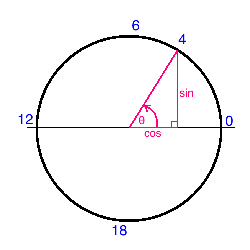
Fuente: http://blog.davidkaleko.com/feature-engineering-cyclical-features.html

For the hours:

In [12]:
df['sin_hour'] = np.sin(df['Hour']*(2*np.pi)/24)
df['cos_hour'] = np.cos(df['Hour']*(2*np.pi)/24)

For the months:

In [13]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
df['month'] = labelencoder.fit_transform(df['month'])
df['sin_month'] = np.sin(df['month']*(2*np.pi)/12)
df['cos_month'] = np.cos(df['month']*(2*np.pi)/12)

For the weekdays:

In [14]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
df['Weekday'] = labelencoder.fit_transform(df['Weekday'])
df['sin_weekday'] = np.sin(df['Weekday']*(2*np.pi)/7)
df['cos_weekday'] = np.cos(df['Weekday']*(2*np.pi)/7)

### Fill NaN values

In [15]:
df[['Red_Electrica','IBEX35']]=df[['Red_Electrica','IBEX35']].ffill()

In [16]:
df.drop(['hour','quarter','geo_id','geo_name','datetime_utc','tz_time'],axis=1,inplace=True)

We may interpolate for those values missing for the market spot price:

In [17]:
df['Precio_mercado_SPOT_Intradiario_Sesion_1']=df['Precio_mercado_SPOT_Intradiario_Sesion_1'].interpolate(method='linear', limit_area='inside')
df['Precio_mercado_SPOT_Intradiario_Sesion_2']=df['Precio_mercado_SPOT_Intradiario_Sesion_2'].interpolate(method='linear', limit_area='inside')

For the temperature, the same assumpation will be considered:

In [18]:
df['Temperature']=df['Temperature'].interpolate(method='linear', limit_area='inside')

We may consider that if the programmed generation of power is null it may be because it is considered 0:

In [19]:
df[df.columns[pd.Series(df.columns).str.contains('Correccion|Generacion')]]=df[df.columns[pd.Series(df.columns).str.contains('Correccion|Generacion')]].fillna(0)

If we want to consider the effect of the date, we need to create a column in which we will put the day, another one for the month and the last one for the year.

Let's merge all the columns for the generation of power:

In [20]:
idx = df.columns.str.startswith('Generacion')
df['Generacion'] = df.iloc[:,idx].sum(axis=1)

In [21]:
idx = df.columns.str.startswith('Demanda')
df['Demanda'] = df.iloc[:,idx].sum(axis=1)

### Correlations

In [22]:
df.corr().style.background_gradient(cmap='coolwarm')

In [23]:
y_corr = df.corr()['Termino_de_facturacion_de_energia_activa_del_PVPC_eficiencia_2_periodos_(DHA)']
y_corr[(y_corr>0.3)|(y_corr<-0.3)]

Termino_de_facturacion_de_energia_activa_del_PVPC_eficiencia_2_periodos_(DHA)    1.000000
Demanda_programada_P48_total                                                     0.570685
Precio_mercado_SPOT_Diario                                                       0.545534
Precio_mercado_SPOT_Intradiario_Sesion_1                                         0.535962
Precio_mercado_SPOT_Intradiario_Sesion_2                                         0.529202
Generacion_programada_P48_Consumo_bombeo                                         0.412708
Generacion_programada_P48_Enlace_Baleares                                       -0.452440
Generacion_programada_P48_Gas_Natural_Cogeneracion                               0.327345
Generacion_programada_P48_Hulla_antracita                                        0.305893
Generacion_programada_P48_Hulla_sub-bituminosa                                   0.348492
Generacion_programada_P48_Solar_termica                                          0.355835
Hour      

In [24]:
idx = df.columns.str.startswith('Generacion_')
df['Generacion_corr'] = df.iloc[:,idx].sum(axis=1)

### Statistics

In [25]:
df.describe()

,Termino_de_facturacion_de_energia_activa_del_PVPC_eficiencia_2_periodos_(DHA),Demanda_programada_P48_total,Precio_mercado_SPOT_Diario,Precio_mercado_SPOT_Intradiario_Sesion_1,Precio_mercado_SPOT_Intradiario_Sesion_2,Demanda_programada_P48_Correccion_eolica,Demanda_programada_P48_Correccion_solar,Generacion_programada_P48_Biogas,Generacion_programada_P48_Biomasa,Generacion_programada_P48_Ciclo_combinado,...,Hour,sin_hour,cos_hour,sin_month,cos_month,sin_weekday,cos_weekday,Generacion,Demanda,Generacion_corr
count,55726.000000,55726.000000,55726.000000,55726.00000,55726.000000,55726.000000,55726.000000,55726.000000,55726.000000,55726.000000,...,55726.000000,5.572600e+04,5.572600e+04,5.572600e+04,5.572600e+04,55726.000000,55726.000000,55726.000000,55726.000000,55726.000000
mean,91.820804,28286.150759,47.347393,47.05100,47.028324,-18.574814,-43.834072,65.569578,394.012493,3638.476677,...,11.499605,1.361697e-05,-3.287426e-05,2.639232e-02,-3.789845e-02,-0.000559,0.000127,27714.980533,28223.741873,27714.980533
std,39.051148,4669.081255,14.868586,14.96884,14.992554,462.319655,234.958484,40.557815,107.375300,2497.072172,...,6.922059,7.071218e-01,7.071045e-01,7.057882e-01,7.069286e-01,0.707163,0.707063,4773.761445,4605.842316,4773.761445
min,10.000000,16428.400000,0.030000,0.00000,0.000000,-3800.000000,-2600.000000,0.000000,141.200000,307.000000,...,0.000000,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-0.974928,-0.900969,14344.300000,16238.000000,14344.300000
25%,60.500000,24384.125000,38.830000,38.50000,38.570000,-300.000000,-100.000000,11.300000,324.600000,1855.825000,...,5.250000,-7.071068e-01,-7.071068e-01,-5.000000e-01,-8.660254e-01,-0.781831,-0.900969,23915.100000,24388.100000,23915.100000
50%,78.565000,28427.950000,48.400000,48.00000,48.000000,0.000000,0.000000,87.600000,357.000000,2797.800000,...,11.000000,1.224647e-16,-1.836970e-16,1.224647e-16,-1.836970e-16,0.000000,-0.222521,27583.300000,28306.750000,27583.300000
75%,130.490000,31862.025000,57.890000,57.51000,57.330000,200.000000,0.000000,93.400000,486.200000,4679.375000,...,17.000000,7.071068e-01,7.071068e-01,8.660254e-01,5.000000e-01,0.781831,0.623490,31294.025000,31727.400000,31294.025000
max,221.370000,41297.900000,101.990000,102.49000,103.610000,3930.000000,1800.000000,150.200000,661.400000,16938.700000,...,23.000000,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.974928,1.000000,42736.400000,41366.600000,42736.400000


In [26]:
prof = ProfileReport(df)
prof.to_file(output_file='output.html')

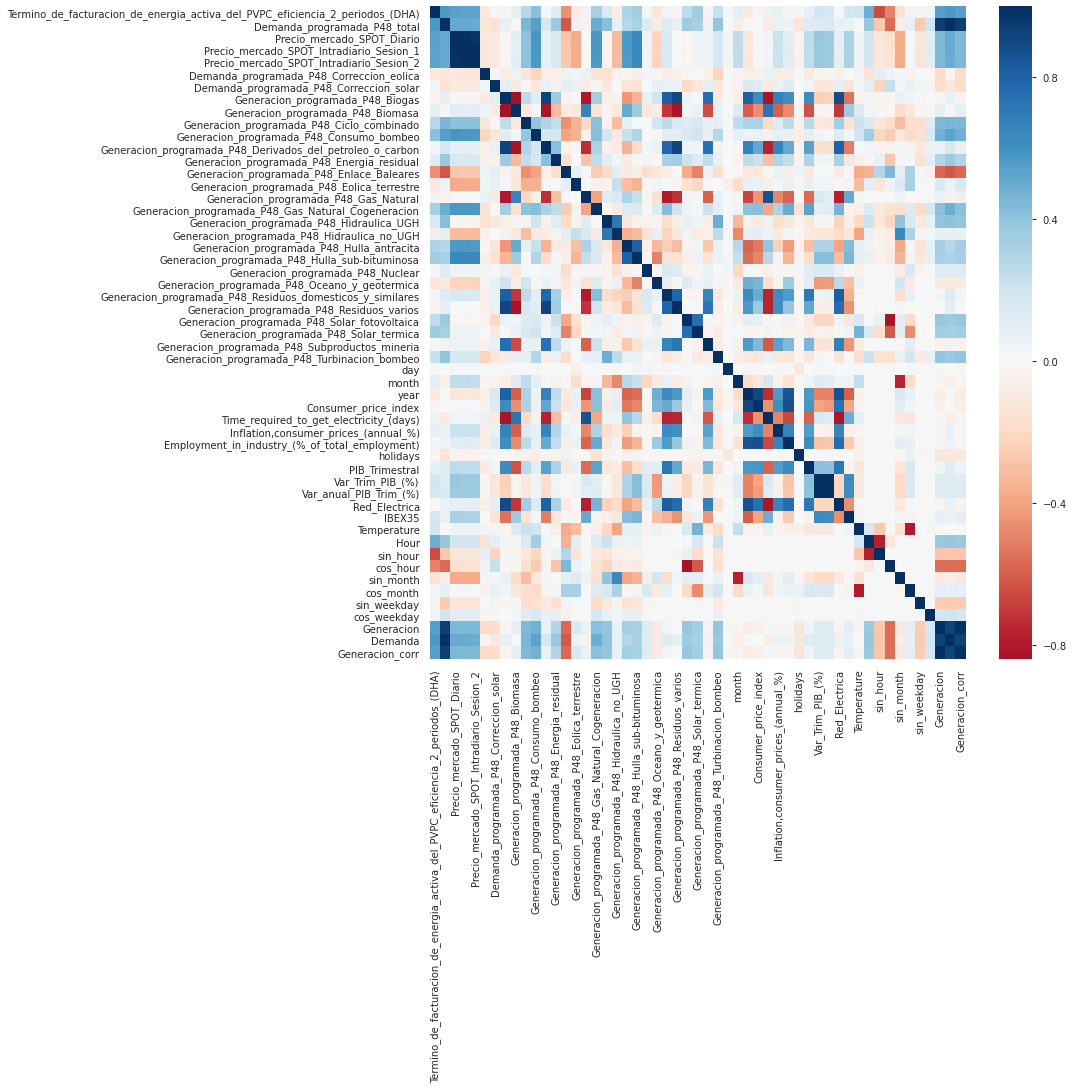

In [27]:
plt.rcParams['figure.figsize'] = [12, 12]
sns.heatmap(df.drop('Weekday',axis=1).corr(),cmap='RdBu',center=0)

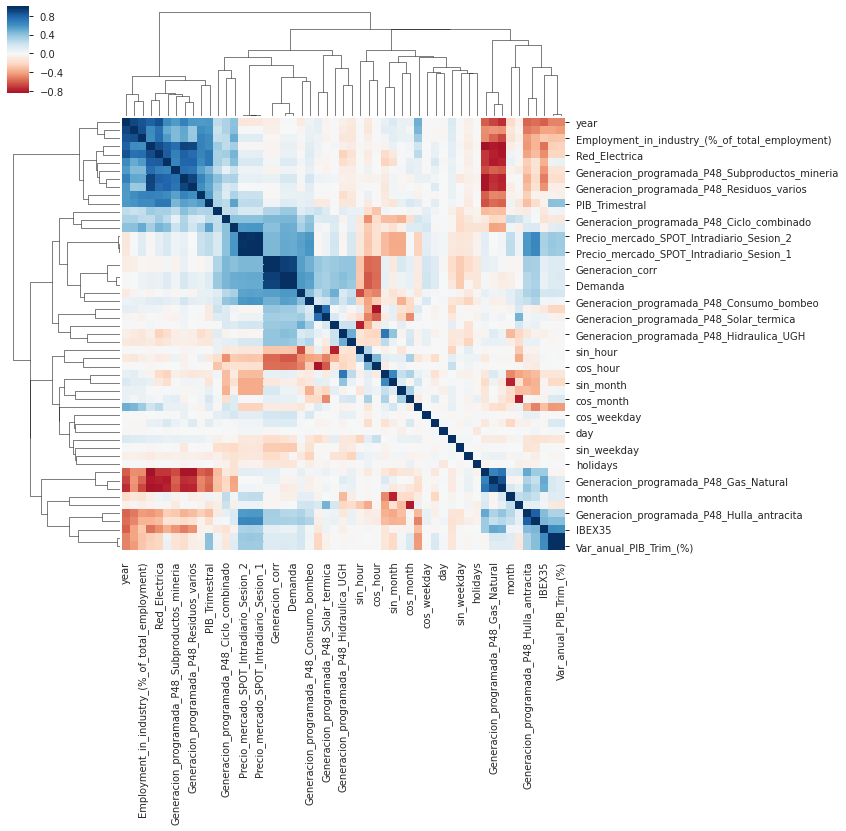

In [28]:
sns.clustermap(df.drop('Weekday',axis=1).corr(),cmap='RdBu',center=0)

In [29]:
df.to_csv('../Models/final_dataframe.csv')